In [348]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob


def get_experiment_data(experiment_name: str):
    for exp_dir in sorted(glob.glob(f'data/{experiment_name}_*')):
        exp_name = exp_dir.rpartition("/")[-1]
        csv_path = f'{exp_dir}/VM_runtime_app_{exp_name}.csv'
        df = pd.read_csv(csv_path, sep=',', skiprows=28)
        yield exp_name, df.get(['time', 'time_h', 'ai_name', 'app_throughput', 'app_latency'])

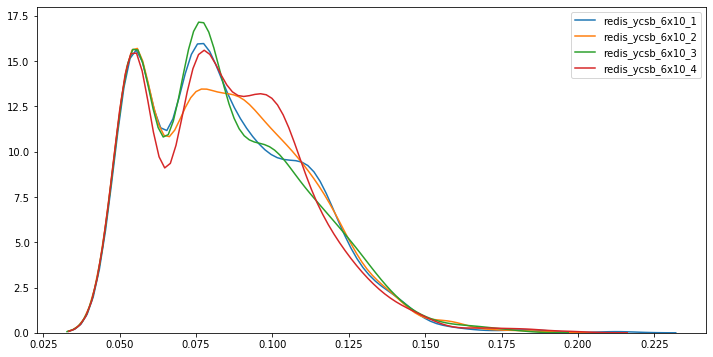

In [345]:
def plot_kde(experiment: str, metric_name: str):
    plt.rcParams["figure.figsize"] = [12,6]
    
    for exp_name, df in get_experiment_data(experiment):
        df = df[df['ai_name'] == 'ai_1']
        sns.kdeplot(data=df[metric_name], label=exp_name)
    plt.show()


plot_kde('redis_ycsb_6x10', 'app_latency')

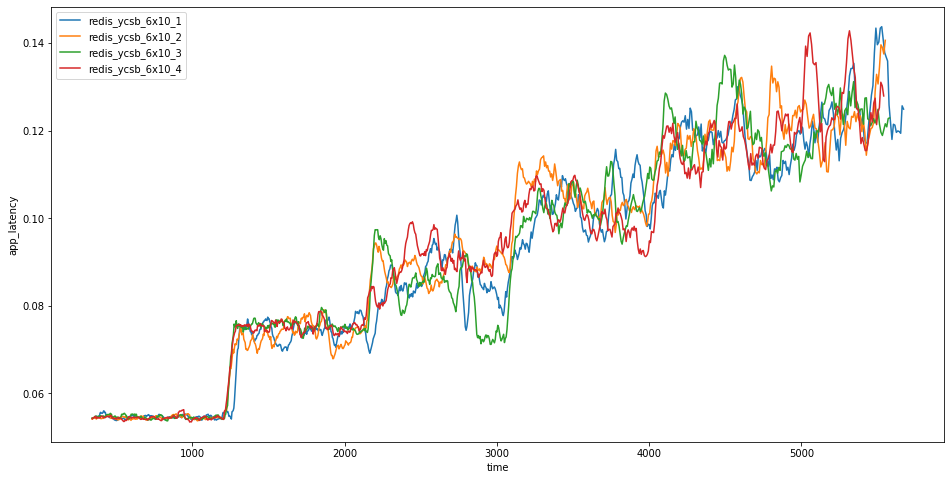

In [337]:
def plot_line(experiment: str, metric_name: str, window_size=10):
    plt.rcParams["figure.figsize"] = [16,8]

    for exp_name, df in get_experiment_data(experiment):
        df = df[df['ai_name'] == 'ai_1']
        sns.lineplot(data=df.rolling(window_size).mean(), x='time', y=metric_name, label=exp_name)
    plt.show()
    

plot_line('redis_ycsb_6x10', 'app_latency')

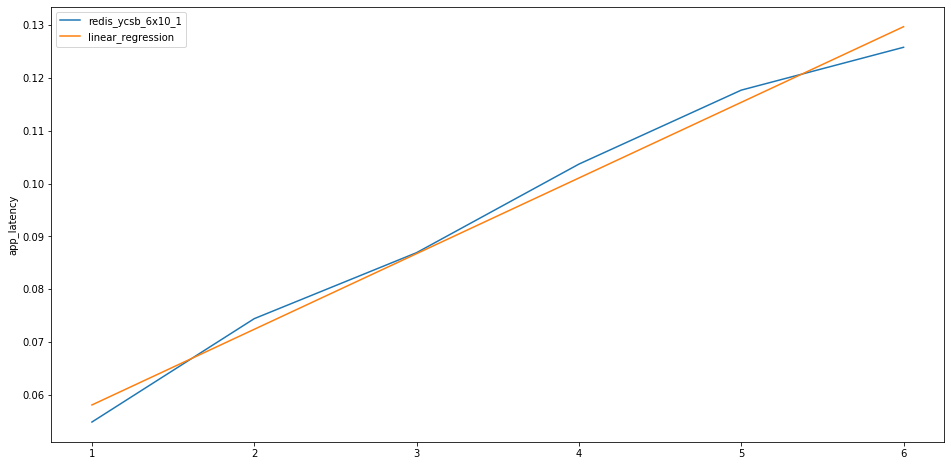

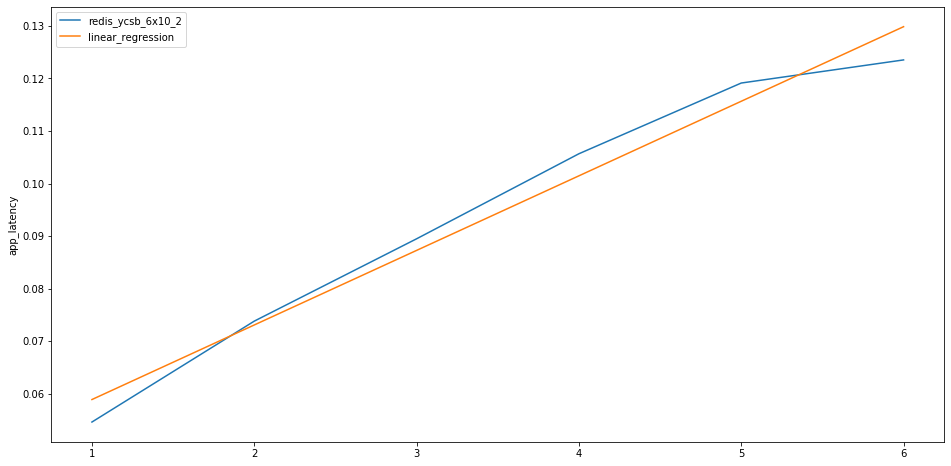

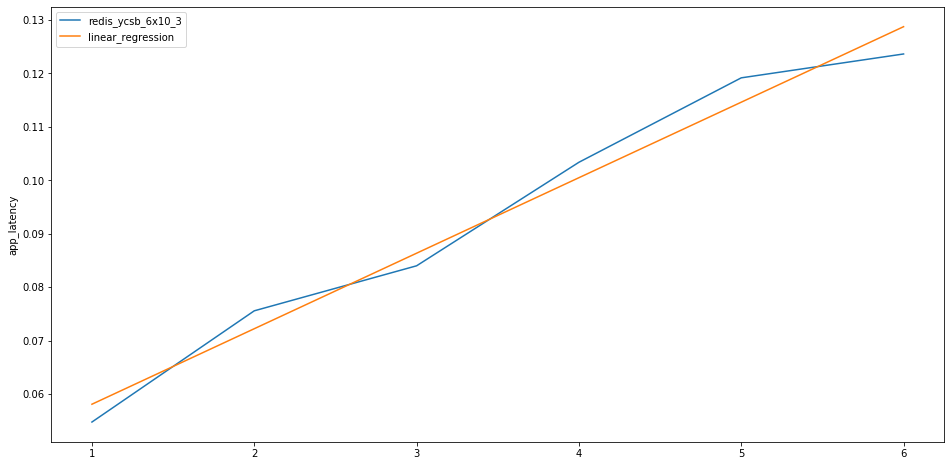

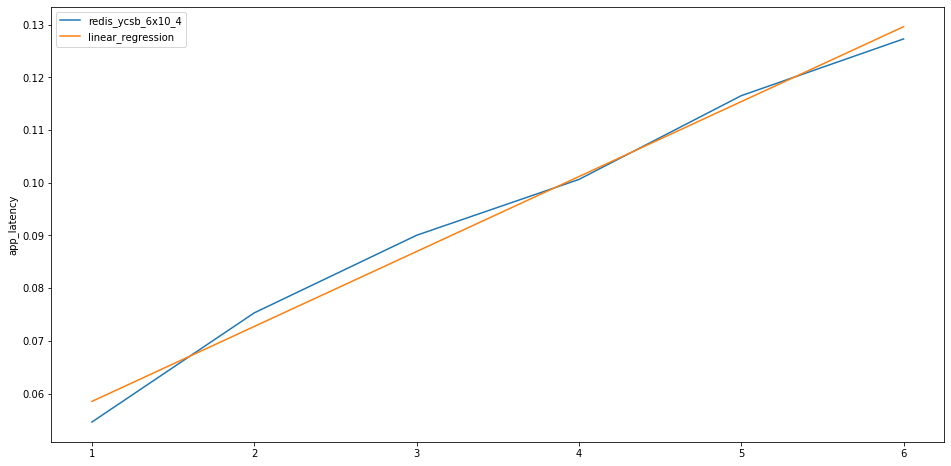

In [334]:
from sklearn.linear_model import LinearRegression


def get_attach_times(df: pd.DataFrame, ai_n=6):
    res = []
    for i in range(1, ai_n+1):
        ai_name = f'ai_{i}' 
        res.append((df['ai_name'] == ai_name).argmax())
    res.append(len(df))
    return res


def get_means(df: pd.DataFrame, instances_n=6):
    attach_times = get_attach_times(df)
    
    means = []
    for i, (a, b) in enumerate(zip(attach_times, attach_times[1:])):
        df_t = df.iloc[a:b]
        df_t = df_t[df_t['ai_name'] == 'ai_1'].mean()
        means.append(df_t)
    return pd.DataFrame(means).drop('time', axis=1)


def get_alpha(df_m: pd.DataFrame, metric_name: str):
    clf = LinearRegression()
    X = np.array(range(1, len(df_m)+1)).reshape(-1, 1)
    clf.fit(X=X, y=df_m[metric_name])
    return clf.intercept_, clf.coef_[0]


def plot_linear_regression(experiment: str, metric_name: str, instances_n=6):
    for exp_name, df in get_experiment_data(experiment):
        df_m = get_means(df)
        b = get_alpha(df_m, metric_name)
        xs = list(range(1, len(df_m)+1))
        y = [b[0] + x * b[1] for x in xs]
        sns.lineplot(x=xs, y=df_m[metric_name], label=exp_name)
        sns.lineplot(x=xs, y=y, label='linear_regression')
        plt.show()


plot_linear_regression('redis_ycsb_6x10', 'app_latency')